## Lexcial Complexity Prediction

In [ ]:
#!pip install syllapy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import syllapy
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Importing train Lexical complexity dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset path
train_single_path = '/content/drive/MyDrive/NLP/lcp_single_train.tsv'

# verifying that file exists or not
if os.path.exists(train_single_path):
    print("lexcial complexity train dataset found")
else :
    print("lexical complexity train dataset doesn't exist")

#Loading dataset
train_single = pd.read_csv(train_single_path, sep='\t')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lexcial complexity train dataset found


## Importing test Lexical complexity dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# File path
test_single_path = '/content/drive/MyDrive/NLP/lcp_single_test.tsv'

# verifing
if os.path.exists(test_single_path):
    print("lexicon complexity test dataset found")
else :
    print("lexicon complexity test dataset doesn't exist")

#Loading Dataset
test_single = pd.read_csv(test_single_path, sep='\t')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lexicon complexity test dataset found


## 1. Data Exploration

In [ ]:
train_single.head()

,id,corpus,sentence,token,complexity
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,"Behold, there came up out of the river seven c...",river,0.000000
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,I am a fellow bondservant with you and with yo...,brothers,0.000000
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,"The man, the lord of the land, said to us, 'By...",brothers,0.050000
3,3BFNCI9LYKQN09BHXHH9CLSX5KP738,bible,Shimei had sixteen sons and six daughters; but...,brothers,0.150000
4,3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2,bible,He has put my brothers far from me.\tbrothers\...,sons,0.055556


## 1.2 Droping id

In [ ]:
train_single.drop("id", axis=1, inplace=True)
test_single.drop("id", axis=1, inplace=True)

In [ ]:
train_single.head()

,corpus,sentence,token,complexity
0,bible,"Behold, there came up out of the river seven c...",river,0.000000
1,bible,I am a fellow bondservant with you and with yo...,brothers,0.000000
2,bible,"The man, the lord of the land, said to us, 'By...",brothers,0.050000
3,bible,Shimei had sixteen sons and six daughters; but...,brothers,0.150000
4,bible,He has put my brothers far from me.\tbrothers\...,sons,0.055556


## 1.3 Missing Values

In [ ]:
train_single.isnull().sum()

,0
corpus,0
sentence,0
token,7
complexity,0


In [ ]:
train_single.dropna(inplace=True)
test_single.dropna(inplace=True)

In [ ]:
train_single.isnull().sum()

,0
corpus,0
sentence,0
token,0
complexity,0


## 2. EDA

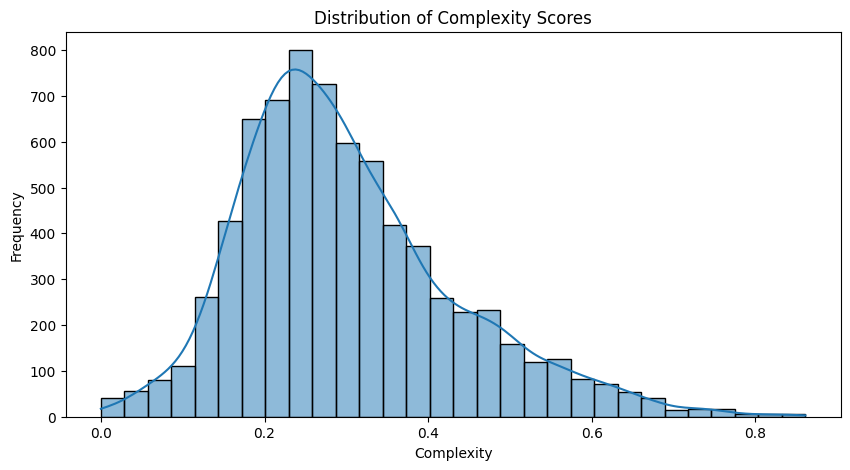

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(train_single['complexity'], bins=30, kde=True)
plt.title("Distribution of Complexity Scores")
plt.xlabel("Complexity")
plt.ylabel("Frequency")
plt.show()

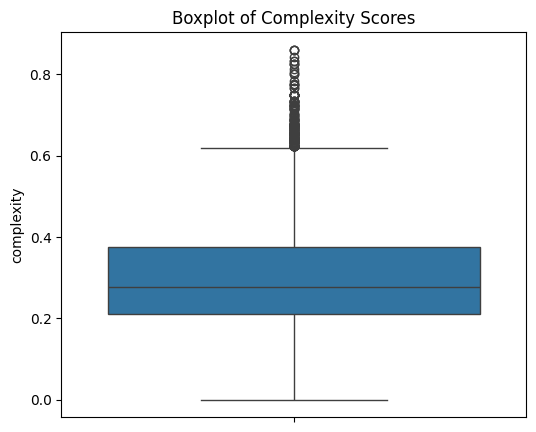

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(y=train_single['complexity'])
plt.title("Boxplot of Complexity Scores")
plt.show()

# 3. Data Preprocessing

In [ ]:
def data_preprocess(text):
    text = re.sub(r'@\w+', '', text) #Removing mentions
    text = re.sub(r'#\w+', '', text) # hashtags
    punctuation_table = str.maketrans('', '', string.punctuation) # punctuation
    text = text.translate(punctuation_table)

    # Tokenization
    tokens = word_tokenize(text.lower())

    # lemmatization and stopwords removing
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

In [ ]:
#nltk.download('punkt_tab')

In [ ]:
train_single['cleaned_sentence'] = train_single['sentence'].apply(data_preprocess)
test_single['cleaned_sentence'] = test_single['sentence'].apply(data_preprocess)

In [ ]:
train_single.head()

,corpus,sentence,token,complexity,cleaned_sentence
0,bible,"Behold, there came up out of the river seven c...",river,0.000000,behold came river seven cattle sleek fat fed m...
1,bible,I am a fellow bondservant with you and with yo...,brothers,0.000000,fellow bondservant brother prophet keep word book
2,bible,"The man, the lord of the land, said to us, 'By...",brothers,0.050000,man lord land said u know honest men leave one...
3,bible,Shimei had sixteen sons and six daughters; but...,brothers,0.150000,shimei sixteen son six daughter brother didnt ...
4,bible,He has put my brothers far from me.\tbrothers\...,sons,0.055556,put brother far brother bible therefore urge b...


In [ ]:
test_single.head()

,corpus,sentence,token,complexity,cleaned_sentence
0,bible,"But he, beckoning to them with his hand to be ...",hand,0.000000,beckoning hand silent declared lord brought pr...
1,bible,"If I forget you, Jerusalem, let my right hand ...",hand,0.197368,forget jerusalem let right hand forget skill
2,bible,"the ten sons of Haman the son of Hammedatha, t...",hand,0.200000,ten son haman son hammedatha jew enemy didnt l...
3,bible,Let your hand be lifted up above your adversar...,hand,0.267857,let hand lifted adversary let enemy cut
4,bible,"Abimelech chased him, and he fled before him, ...",entrance,0.000000,abimelech chased fled many fell wounded even e...


# 4. Feature Engineering                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 4.1 TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)

In [ ]:
X_train_tfidf = tfidf.fit_transform(train_single['cleaned_sentence'])
X_test_tfidf = tfidf.transform(test_single['cleaned_sentence'])

In [ ]:
train_single['word_length'] = train_single['token'].apply(len)
test_single['word_length'] = test_single['token'].apply(len)

## 4.2 Word Frequency

In [ ]:
#!pip install wordfreq

In [ ]:
from wordfreq import word_frequency

In [ ]:
train_single['word_freq'] = train_single['token'].apply(lambda x: word_frequency(x, 'en'))
test_single['word_freq'] = test_single['token'].apply(lambda x: word_frequency(x, 'en'))

In [ ]:
train_single['syllable_count'] = train_single['token'].apply(lambda x: syllapy.count(x))
test_single['syllable_count'] = test_single['token'].apply(lambda x: syllapy.count(x))

## 4.3 Train-Test Split

In [ ]:
X_train_extra = train_single[['word_length', 'word_freq', 'syllable_count']].values
X_test_extra = test_single[['word_length', 'word_freq', 'syllable_count']].values

## 4.4 Standard Scalar

In [ ]:
scaler = StandardScaler()
X_train_extra_scaled = scaler.fit_transform(X_train_extra)
X_test_extra_scaled = scaler.transform(X_test_extra)

In [ ]:
train_single.head()

,corpus,sentence,token,complexity,cleaned_sentence,word_length,word_freq,syllable_count
0,bible,"Behold, there came up out of the river seven c...",river,0.000000,behold came river seven cattle sleek fat fed m...,5,0.000107,2
1,bible,I am a fellow bondservant with you and with yo...,brothers,0.000000,fellow bondservant brother prophet keep word book,8,0.000049,2
2,bible,"The man, the lord of the land, said to us, 'By...",brothers,0.050000,man lord land said u know honest men leave one...,8,0.000049,2
3,bible,Shimei had sixteen sons and six daughters; but...,brothers,0.150000,shimei sixteen son six daughter brother didnt ...,8,0.000049,2
4,bible,He has put my brothers far from me.\tbrothers\...,sons,0.055556,put brother far brother bible therefore urge b...,4,0.000032,1


In [ ]:
test_single.head()

,corpus,sentence,token,complexity,cleaned_sentence,word_length,word_freq,syllable_count
0,bible,"But he, beckoning to them with his hand to be ...",hand,0.000000,beckoning hand silent declared lord brought pr...,4,0.000257,1
1,bible,"If I forget you, Jerusalem, let my right hand ...",hand,0.197368,forget jerusalem let right hand forget skill,4,0.000257,1
2,bible,"the ten sons of Haman the son of Hammedatha, t...",hand,0.200000,ten son haman son hammedatha jew enemy didnt l...,4,0.000257,1
3,bible,Let your hand be lifted up above your adversar...,hand,0.267857,let hand lifted adversary let enemy cut,4,0.000257,1
4,bible,"Abimelech chased him, and he fled before him, ...",entrance,0.000000,abimelech chased fled many fell wounded even e...,8,0.000024,2


In [ ]:
X_train = np.hstack((X_train_tfidf.toarray(), X_train_extra_scaled))
X_test = np.hstack((X_test_tfidf.toarray(), X_test_extra_scaled))
y_train = train_single['complexity']
y_test = test_single['complexity']

## 5 Model Evaluation

In [ ]:
# Initialize Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=10, gamma=0.1),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
}

results = {}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "MAE": mae, "R² Score": r2}

In [ ]:
result_df = pd.DataFrame(results).T
result_df

,MSE,MAE,R² Score
Linear Regression,0.064784,0.182665,-2.950803
Random Forest,0.008270,0.069978,0.495638
Support Vector Regressor,0.011942,0.084974,0.271755
XGBoost,0.008051,0.068993,0.509022


# 6 Conclusion

In [ ]:
# Display Results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:\n")
print(results_df)


Model Performance Comparison:

                               MSE       MAE  R² Score
Linear Regression         0.064784  0.182665 -2.950803
Random Forest             0.008270  0.069978  0.495638
Support Vector Regressor  0.011942  0.084974  0.271755
XGBoost                   0.008051  0.068993  0.509022


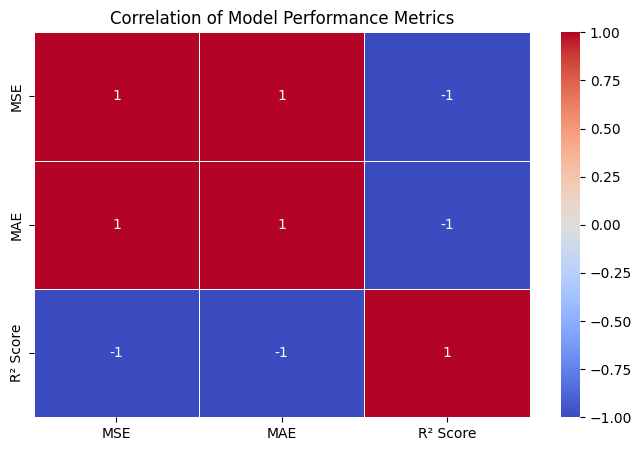

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from results to compute correlations
correlation_df = pd.DataFrame({
    "MSE": [results[model]["MSE"] for model in models],
    "MAE": [results[model]["MAE"] for model in models],
    "R² Score": [results[model]["R² Score"] for model in models]
}, index=models.keys())

# Step 9: Heatmap of Correlations
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Model Performance Metrics")
plt.show()